# Table of contents
- [Data importation](#importation)
- [Descriptive analysis](#descriptive-analysis)
- [Heaps' law](#heaps)
- [Zipf's law](#zipf)
- [Preprocessing](#preprocessing)
- [AG News](#ag-news)
- [Brown Corpus](#brown)
- [20 Newsgroup](#ng)
- [LSA](#lsa)

In [2]:
from sklearn.datasets import fetch_20newsgroups
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import unidecode
import json
import re
import Stemmer
from nltk.stem import SnowballStemmer
# !python -m spacy download en_core_web_sm
import en_core_web_sm
from nltk import ngrams

from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB 
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

<a id="importation"></a>
# Data importation

In [3]:
ng = fetch_20newsgroups(subset="train")
df_ng_train = pd.DataFrame(np.c_[ng["data"], ng["target"]], columns= np.append("text", ["category"]))

ng = fetch_20newsgroups(subset="test")
df_ng_test = pd.DataFrame(np.c_[ng["data"], ng["target"]], columns= np.append("text", ["category"]))

map_ng_label = {i:category for i, category in enumerate(ng.target_names)}
df_ng_train["category"] = df_ng_train["category"].apply(lambda x: map_ng_label[int(x)])
df_ng_test["category"] = df_ng_test["category"].apply(lambda x: map_ng_label[int(x)])

In [4]:
df_brown = pd.read_json("brown_corpus.json")

In [5]:
df_ag_train = pd.read_csv("train.csv", names=["category", "title", "content"])
df_ag_train["category"] = df_ag_train["category"].map({1: 'world', 2: 'sports', 3: 'business', 4: 'sci/tech'})
df_ag_train["text"] = df_ag_train["title"] + " " + df_ag_train["content"]

<a id="descriptive-analysis"></a>
# Descriptive analysis

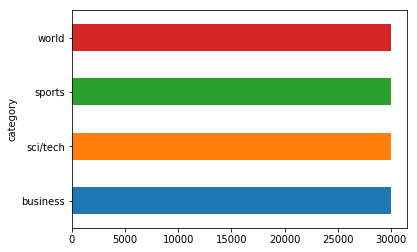

In [6]:
df_ag_train.groupby("category").size().plot(kind="barh")

In [7]:
print("Average text size:", df_ag_train["text"].apply(lambda x: len(x)).mean())

Average text size: 236.477525


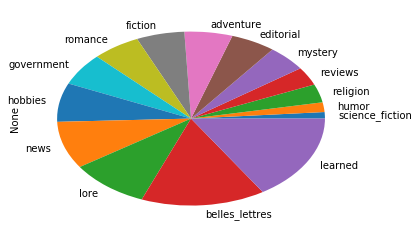

In [8]:
df_brown.groupby("category").size().sort_values().plot(kind="pie")

In [9]:
df_brown.groupby("category").count()\
    .sort_values(by="text", ascending=False)\
    .reset_index().assign(percentage=\
    (df_brown.groupby("category").size()\
    .sort_values(ascending=False)/len(df_brown)*100)\
    .tolist())[["category", "text", "percentage"]]

,category,text,percentage
0,learned,80,16.0
1,belles_lettres,75,15.0
2,lore,48,9.6
3,news,44,8.8
4,hobbies,36,7.2
5,government,30,6.0
6,adventure,29,5.8
7,fiction,29,5.8
8,romance,29,5.8
9,editorial,27,5.4


In [10]:
print("Average text size:", df_brown["text"].apply(lambda x: len(x)).mean())

Average text size: 12110.99


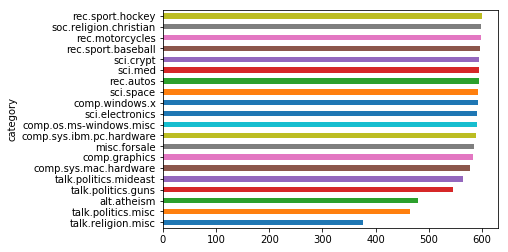

In [11]:
df_ng_train.groupby("category").size().sort_values().plot(kind="barh")

In [12]:
df_ng_train.groupby("category").count()\
    .sort_values(by="text", ascending=False)\
    .reset_index().assign(percentage=\
    (df_ng_train.groupby("category").size()\
    .sort_values(ascending=False)/len(df_ng_train)*100)\
    .tolist())[["category", "text", "percentage"]]

,category,text,percentage
0,rec.sport.hockey,600,5.303164
1,soc.religion.christian,599,5.294326
2,rec.motorcycles,598,5.285487
3,rec.sport.baseball,597,5.276648
4,sci.crypt,595,5.258971
5,rec.autos,594,5.250133
6,sci.med,594,5.250133
7,comp.windows.x,593,5.241294
8,sci.space,593,5.241294
9,sci.electronics,591,5.223617


In [13]:
len(df_ng_test) + len(df_ng_train)

18846

In [14]:
print("Average text size:", df_ng_train["text"].apply(lambda x: len(x)).mean())

Average text size: 1949.3100583348064


<a id="heaps"></a>
# Heaps' law

In [15]:
# List of undesired punctuations and punctuation marks for word/token normalization
ignorechars = ["!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "[", "]",\
               "{", "}", ";", ":", ",", ".", "/", "<", ">", "?", "\\", "|",\
               "`", "~", "-", "=", "_", "+", '"']

In [16]:
# A simple word normalizer for plotting Heaps' and Zipf's laws
def normalize_basic(word):
    word = word.strip()
    
    for punctuation in ignorechars:
        word = word.replace(punctuation, " ")

    word = word.strip()
    re.sub("\s+", " ", word)
        
    return word

In [17]:
def plot_heaps(df_text, title=None, stopwords=False, pystemmer=False):
    list_text = df_text.tolist()
    list_word = []
    word_count = []
    list_text_size = []
    text_len = 0
    len_count = []

    for text in tqdm(list_text):
        text = unidecode.unidecode(text)
        text = text.lower()
        text = text.replace("\\", " ")
#        list_word += [word.strip().lower() for word in text.split()]
        for word in text.split():
            word = normalize_basic(word)
            if word: 
                list_word.append(word)
        list_word = list(set(list_word))
        word_count.append(len(list_word))
        text_len += len(text)
        len_count.append(text_len)

    plt.plot(len_count, word_count)
    plt.title(f"Heaps' Law {title}")
    plt.xlabel("Document size")
    plt.ylabel("Number of distinct words")

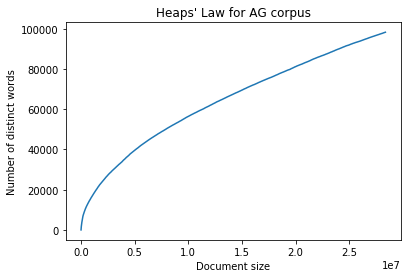

In [18]:
plot_heaps(df_ag_train["text"], "for AG corpus")

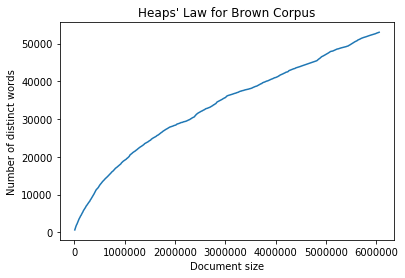

In [19]:
plot_heaps(df_brown["text"], "for Brown Corpus")

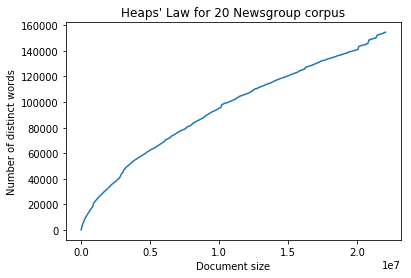

In [20]:
plot_heaps(df_ng_train["text"], "for 20 Newsgroup corpus")

<a id="zipf"></a>
# Zipf's law

In [21]:
from collections import Counter

def plot_zipf(df_text, title=None, rank=10):
    word_all = []
    list_text = df_text.tolist()
    for text in tqdm(list_text):
        for word in text.split():
            word = normalize_basic(word)
            if word:
                word_all.append(word)
    word_frequency = Counter(word_all)
    list_rank, list_frequency = list(zip(*word_frequency.most_common(rank)))
    fig, ax = plt.subplots()
    ax.set_yscale("log")
#    ax.set_xscale("log")
#    plt.scatter([x for x in range(rank)], list_frequency)
    plt.plot([x for x in range(rank)], list_frequency)
    plt.title(f"Zipf's Law {title}")
    plt.xlabel("Rank")
    plt.ylabel("log(frequency)")
    print([(i, elt) for i, elt in enumerate(list_rank)])


[(0, 'the'), (1, 'to'), (2, 'a'), (3, 'of'), (4, 'in'), (5, 'and'), (6, 'on'), (7, 'for'), (8, '39 s'), (9, 'that')]


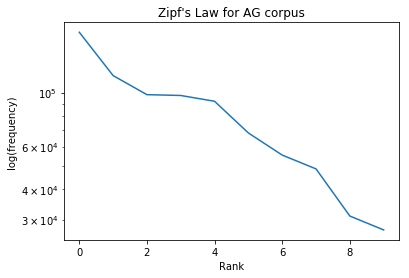

In [22]:
plot_zipf(df_ag_train["text"], "for AG corpus")


[(0, 'the'), (1, 'of'), (2, 'and'), (3, 'to'), (4, 'a'), (5, 'in'), (6, 'that'), (7, 'is'), (8, 'was'), (9, 'for')]


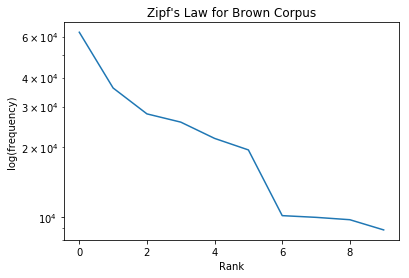

In [23]:
plot_zipf(df_brown["text"], "for Brown Corpus")


[(0, 'the'), (1, 'to'), (2, 'of'), (3, 'a'), (4, 'and'), (5, 'is'), (6, 'I'), (7, 'in'), (8, 'that'), (9, 'for')]


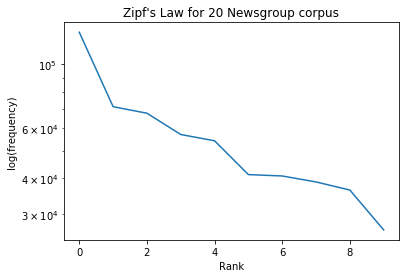

In [24]:
plot_zipf(df_ng_train["text"], "for 20 Newsgroup corpus")

<a id="preprocessing"></a>
# Preprocessing

In [25]:
# spaCy lemmatizer
parser = en_core_web_sm.load()

def lemmatizer_spacy(text):
    parsedData = parser(text)
    list_lemma = [token.lemma_ for token in parsedData]
    return " ".join(list_lemma)

# NLTK Porter stemmer
stemmer = SnowballStemmer("english")


def stemmer_nltk(word):
    return stemmer.stem(word)

# pystemmer
pystemmer = Stemmer.Stemmer('english')

In [76]:
# List of undesired punctuations and punctuation marks for word/token normalization
ignorechars = ["!", "@", "#", "$", "%", "^", "&", "*", "(", ")", "[", "]",\
               "{", "}", ";", ":", ",", ".", "/", "<", ">", "?", "\\", "|",\
               "`", "~", "-", "=", "_", "+", '"']

with open("stopwords_en.json", "r") as f:
    stopwords = json.load(f)

# Try with and without question nouns
stopwords = [word for word in stopwords if not word in ["what", "when", "why", "where", "who", "whom", "how"]]

def normalize(token):
    token = token.strip()
    
    for punctuation in ignorechars:
        token = token.replace(punctuation, " ")
    token = token.replace("'", "")
    
    # Replace apostrophe from words else they return False to isalpha()
    re.sub("\s+", " ", token)
    
    if not token in stopwords and token.isalpha():
        return token.strip()
    
    
def parse(document, pystemmer_=False, stemmer_nltk_=False, lemmatizer_=False, ngrams_=False, n=None):
    re.sub("\s+", " ", document)
    document = document.strip()
    document = unidecode.unidecode(document)
    document = document.lower()
    # Specific to the AG corpus
    document = document.replace("\\", " ")
    list_token = [word for word in document.split()]
    list_token = [normalize(token) for token in list_token if normalize(token)]
     
    if pystemmer_:
        list_token = [pystemmer.stemWord(token) for token in list_token]
    elif stemmer_nltk_:
        list_token = [stemmer_nltk(token) for token in list_token]
    elif lemmatizer_:
        list_token = [lemmatizer_spacy(token) for token in list_token]
        
    if ngrams_ and n:
        list_token = [gram for gram in ngrams(list_token, n)]
        
    histogram = Counter(list_token)
    
    return dict(histogram)


def vectorize(histograms):
    vectorizer = DictVectorizer()
    return vectorizer.fit_transform(histograms), vectorizer.feature_names_, vectorizer


def classify_and_evaluate(X, y):
    clf = MultinomialNB()
    predictions = cross_val_predict(clf, X, y, cv=5)
    print("Nombre d'erreurs :", len([(truth, prediction)\
                                     for truth, prediction in zip(y, predictions)\
                                     if truth != prediction]))
    print("Error percentage :", len([(truth, prediction)\
                                     for truth, prediction in zip(y, predictions)\
                                     if truth != prediction])/len(y)*100)
#    print(classification_report(y, cross_val_predict(cls, X, y, cv=3)))
    print("Cross validated score :", cross_val_score(clf, X, y, cv=5).mean(), end="\n\n")

In [27]:
def pipeline_preprocessing(df_text, 
                           df_target, 
                           n_count=3, 
                           pystemmer_=False, 
                           stemmer_nltk_=False, 
                           lemmatizer_=False, 
                           tfidf=False, 
                           ngrams_=False,
                           n=None):
    list_text = df_text.tolist()
    y = df_target.tolist()
    histograms = [parse(document, pystemmer_, stemmer_nltk_, lemmatizer_, ngrams_, n) for document in tqdm(list_text)]
    X, feature_names, vectorizer = vectorize(histograms)

    columns_selection = (X.sum(axis=0) > n_count).A.ravel()
    X = X[:, columns_selection]
    
    if tfidf: 
        X = TfidfTransformer(norm=False).fit_transform(X)
    
    return X, y, feature_names
#    return histograms

<a id="ag-news"></a>
# AG News

### Without stemming, without TFIDF vectorization

In [79]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                                   df_ag_train["category"])
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 29s, sys: 1.7 s, total: 1min 30s
Wall time: 1min 44s
Nombre d'erreurs : 12929
Error percentage : 10.774166666666666
Cross validated score : 0.8922583333333332

CPU times: user 1.65 s, sys: 145 ms, total: 1.8 s
Wall time: 1.81 s

... X.shape: (120000, 26938)


### With stemming (pystemmer)

Comment:
- Processing: tokenization, normalization, vectorization + stemming with pystemmer
- Performance: a tiny bit worse
- Execution time: unchanged at around 90 seconds
- Matrix shape is however 9,000 columns smaller, which is good since performance does not decrease too much (score at 0.889)

In [80]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             pystemmer_=True)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 26s, sys: 1.58 s, total: 1min 28s
Wall time: 1min 30s
Nombre d'erreurs : 13208
Error percentage : 11.006666666666666
Cross validated score : 0.8899333333333332

CPU times: user 1.64 s, sys: 144 ms, total: 1.79 s
Wall time: 1.79 s

... X.shape: (120000, 17955)


### With stemming (NLTK SnowballStemmer)

Comment:
- Processing: tokenization, normalization, vectorization + stemming with SnowballStemmer
- Performance: same as with pystemmer
- Execution time: longer at around 120 sec, but still acceptable
- Matrix shape is almost exactly the same size (17955 for pystemmer and 17956 for SnowballStemmer)

In [81]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             stemmer_nltk_=True)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 59s, sys: 1.98 s, total: 2min 1s
Wall time: 2min 2s
Nombre d'erreurs : 13208
Error percentage : 11.006666666666666
Cross validated score : 0.8899333333333332

CPU times: user 1.67 s, sys: 150 ms, total: 1.82 s
Wall time: 1.84 s

... X.shape: (120000, 17956)


### With TFIDF

Comment:
- Processing: tokenization, normalization, vectorization + TFIDF
- Performance: a bit worse
- Execution time: between 80 and 90 seconds which is a tiny bit better than the basic model
- Matrix shape is unchanged (26938 columns)

In [82]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             tfidf=True)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 23s, sys: 1.29 s, total: 1min 24s
Wall time: 1min 25s
Nombre d'erreurs : 13558
Error percentage : 11.298333333333334
Cross validated score : 0.8870166666666668

CPU times: user 1.65 s, sys: 138 ms, total: 1.78 s
Wall time: 1.78 s

... X.shape: (120000, 26938)


### With stemming (pystemmer) and TFIDF

Comment:
- Processing: tokenization, normalization, vectorization + pystemmer + TFIDF
- Performance: a bit worse again
- Execution time: good at around 90 sec
- Matrix shape: 17955 columns

In [83]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             tfidf=True, pystemmer_=True)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 29s, sys: 1.52 s, total: 1min 30s
Wall time: 1min 31s
Nombre d'erreurs : 13766
Error percentage : 11.471666666666666
Cross validated score : 0.8852833333333333

CPU times: user 1.65 s, sys: 147 ms, total: 1.79 s
Wall time: 1.81 s

... X.shape: (120000, 17955)


### With stemming (SnowballStemmer) and TFIDF

In [84]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             tfidf=True, stemmer_nltk_=True)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 2min 3s, sys: 2.19 s, total: 2min 5s
Wall time: 2min 8s
Nombre d'erreurs : 13766
Error percentage : 11.471666666666666
Cross validated score : 0.8852833333333333

CPU times: user 1.61 s, sys: 141 ms, total: 1.76 s
Wall time: 1.76 s

... X.shape: (120000, 17956)


### With n-grams

Comment:
- Processing: tokenization, normalization, vectorization + ngrams
- Performance: worse performance with 2000 more errors
- Execution time: good
- Matrix shape: 83324 columns

In [85]:
%time X, y, feature_names = pipeline_preprocessing(df_ag_train["text"],\
                                             df_ag_train["category"],\
                                             ngrams_=True,\
                                             n=2)
%time classify_and_evaluate(X, y)
print("\n... X.shape:", X.shape)


CPU times: user 1min 32s, sys: 1.71 s, total: 1min 33s
Wall time: 1min 34s
Nombre d'erreurs : 18280
Error percentage : 15.233333333333333
Cross validated score : 0.8476666666666667

CPU times: user 1.68 s, sys: 110 ms, total: 1.79 s
Wall time: 1.8 s

... X.shape: (120000, 83324)


## Conclusion
- stemming and TFIDF both worsen the performances
- however stemming reduces the corpus size greatly
- unfortunately TFIDF worsens the performances but we know that weighted words are more useful than simple counts
- pystemmer implementation is faster than SnowballStemmer by a great margin as expected
- n-grams implementation has good execution time but increases the size of the corpus by a large factor
- classification time is the same overall

In [88]:
# Could have automatised the retrieval of values

dict_ag_metrics = {
    "model": ["basic", "pystemmer", "SnowballStemmer", "tfidf", "pystemmer_tfidf", "SnowballStemmer_tfidf", "ngrams"],
    "execution_time": [99, 100, 123, 92, 90, 131, 103], 
    "error": [12079, 12272, 12272, 12609, 12732, 12732, 14944],
    "score": [0.8922, 0.8899, 0.8899, 0.887, 0.885, 0.885, 0.84],
    "matrix_shape": [26938, 17955, 17956, 26938, 17955, 17956, 83324]
}

In [89]:
df_ag_metrics = pd.DataFrame(dict_ag_metrics, columns=["model", "execution_time", "error", "score", "matrix_shape"])

In [90]:
df_ag_metrics

,model,execution_time,error,score,matrix_shape
0,basic,99,12079,0.8922,26938
1,pystemmer,100,12272,0.8899,17955
2,SnowballStemmer,123,12272,0.8899,17956
3,tfidf,92,12609,0.8870,26938
4,pystemmer_tfidf,90,12732,0.8850,17955
5,SnowballStemmer_tfidf,131,12732,0.8850,17956
6,ngrams,103,14944,0.8400,83324


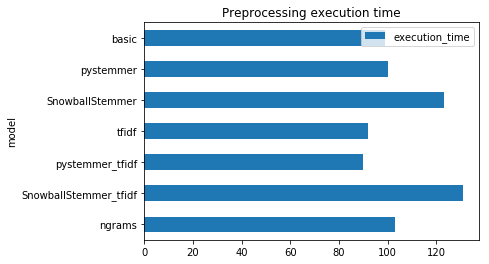

In [91]:
df_ag_metrics[["model", "execution_time"]]\
    .sort_index(ascending=False)\
    .plot(x="model", kind="barh", title="Preprocessing execution time")

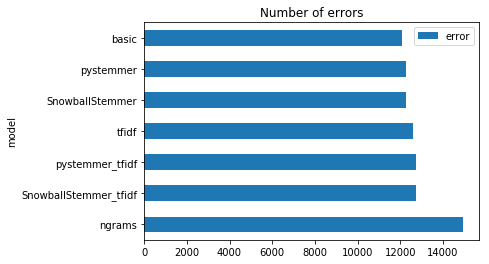

In [92]:
df_ag_metrics[["model", "error"]]\
    .sort_index(ascending=False)\
    .plot(x="model", kind="barh", title="Number of errors")

['basic',
 'pystemmer',
 'SnowballStemmer',
 'tfidf',
 'pystemmer_tfidf',
 'SnowballStemmer_tfidf',
 'ngrams']

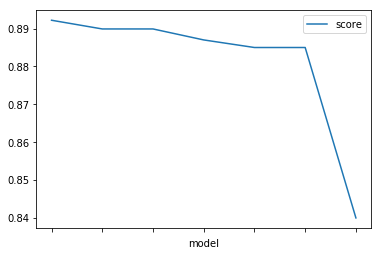

In [93]:
ax = df_ag_metrics[["model", "score"]]\
        .sort_index()\
        .plot(x="model", kind="line")
df_ag_metrics["model"].tolist()
#list_label = df_ag_metrics["model"].tolist()
#ax.set_xticklabels(list_label)
#ax.xaxis.labelpad = 20

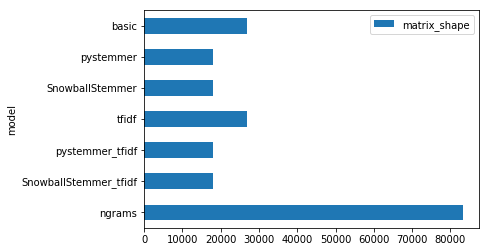

In [94]:
df_ag_metrics[["model", "matrix_shape"]]\
            .sort_index(ascending=False)\
            .plot(x="model", kind="barh")

<a id="brown"></a>
# Brown Corpus

## AG on Brown Corpus

### Comment
- We decide to write a Pipeline class in order to fit_transform, train and predict efficiently
- The AG and Brown corpuses have different labels, number of documents and document sizes
- The documents have large sizes but our model was trained on documents with small sizes. Using our Heaps' law plot, the number of distinct words of the AG corpus is only twice the vocabulary size of the Brown Corpus; it is at least higher but one had 120000 documents and the other only 500 which is tricky for us.
- There are many classes for few documents and we want to classify the Brown Corpus into our 4 existing classes. We first take a look at the model predictions (see [below](#brown-prediction)).

In [42]:
def browse_corpus(corpus, category, index):
    return corpus[corpus["category"]==category].iloc[index]["text"]

In [43]:
browse_corpus(df_ag_train, "world", 3)

'Seven Georgian soldiers wounded as South Ossetia ceasefire violated (AFP) AFP - Sporadic gunfire and shelling took place overnight in the disputed Georgian region of South Ossetia in violation of a fragile ceasefire, wounding seven Georgian servicemen.'

In [44]:
#browse_corpus(df_brown, "humor", 3)

In [100]:
class Pipeline():
    def __init__(self):
        self.df_text_train = None
        self.y = None
        self.dict_vectorizer = DictVectorizer()
        self.tfidf_transformer = TfidfTransformer()
        self.feature_names = None
        self.histograms = None
        self.clf = MultinomialNB()
        self.X = None
        
    def preprocessing(self,
                      df_text, 
                      pystemmer_=False, 
                      stemmer_nltk_=False, 
                      lemmatizer_=False,  
                      ngrams_=False,
                      n=None):
        
        list_text = df_text.tolist()
        histograms = [parse(document, pystemmer_, stemmer_nltk_, lemmatizer_, ngrams_, n) for document in tqdm(list_text)]
        
        return histograms
    
    def fit_transform(self, 
                      df_text_train,
                      n_count=3, 
                      pystemmer_=False, 
                      lemmatizer_=False, 
                      ngrams_=False, 
                      n=None, 
                      tfidf=False):
        self.df_text_train = df_text_train
        self.X = self.dict_vectorizer.fit_transform(self.preprocessing(self.df_text_train))
        self.feature_names = self.dict_vectorizer.feature_names_
        self.columns_selection = (self.X.sum(axis=0) > n_count).A.ravel()
        self.X = self.X[:, self.columns_selection]
        if tfidf:
            self.X = self.tfidf_transformer.fit_transform(self.X)
    
    def transform(self, df_text, pystemmer_=False, tfidf=False):
        histograms = self.preprocessing(df_text, pystemmer_)
        X = self.dict_vectorizer.transform(histograms)
        X = X[:, self.columns_selection]
        if tfidf:
            X = self.tfidf_transformer.fit_transform(X)
        
        return X
    
    # We allow for the model to train new data with an existing vectorizer/corpus
    def train(self, 
              x_train, 
              y_train,
              fit_transform_,
              **kwargs):
        if fit_transform_:
            self.fit_transform(x_train, **kwargs)
        else:
            self.X = self.transform(x_train, **kwargs)
        self.y = y_train.tolist()
        self.clf.fit(self.X, y_train)
        
    def predict(self, df_text):
        y_pred = self.clf.predict(self.transform(df_text))
        return y_pred
    
    def classify_and_evaluate(self, x_test, y_test):
        predictions = self.predict(x_test)
        truth = y_test
        y = y_test
        print("Nombre d'erreurs :", len([(truth, prediction)\
                                         for truth, prediction in zip(y, predictions)\
                                         if truth != prediction]))
        print("Error percentage :", len([(truth, prediction)\
                                         for truth, prediction in zip(y, predictions)\
                                         if truth != prediction])/len(y_test)*100)
        print(classification_report(truth, predictions))

### Comment
- Execution time: the training takes only 118 ms, the prediction takes 16 seconds to transform the corpus and predict its classes

In [104]:
pipeline_ag = Pipeline()
%time pipeline_ag.train(df_ag_train["text"],\
                     df_ag_train["category"],\
                     fit_transform_=True,\
                     pystemmer_=True,\
                     tfidf=True)


CPU times: user 1min 24s, sys: 1.32 s, total: 1min 26s
Wall time: 1min 27s


In [105]:
%time y_pred = pipeline_ag.predict(df_brown["text"])


CPU times: user 15.4 s, sys: 223 ms, total: 15.6 s
Wall time: 16 s


<a id="brown-prediction"></a>
Comment:    
- The model predicts labels for the Brown Corpus which are uneven.
- For instance, sci/tech is predominant although technology was not very developed in the 1960's.

In [106]:
df_brown["predicted"] = y_pred

### Comment
- The model predicts many documents to belong to the sci/tech category: this could be because the learned class documents are heavily proportioned and its documents are closely related to science and contain scientific terms.
- Sports is the second most predicted class. It is maybe related to words which describe actions and dynamic movements.
- World is third and may group news and editorial articles of the Brown Corpus which mention countries for example, terms related to worldwide events
- Business is last with less than 10 percent and it may be because the Brown Corpus does not contain many articles related to finance, economy

Remark: I should have checked words with high occurrences in order to find elements supporting my assumptions

In [49]:
df_brown["predicted"].value_counts().reset_index()\
    .assign(percentage=(df_brown["predicted"]\
    .value_counts()/len(df_brown)*100).tolist())

,index,predicted,percentage
0,sci/tech,201,40.2
1,sports,143,28.6
2,world,115,23.0
3,business,41,8.2


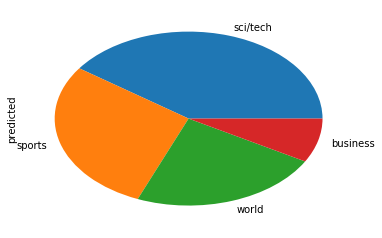

In [50]:
df_brown["predicted"].value_counts().plot(kind="pie")

In [51]:
print(df_ag_train["category"].value_counts().index.tolist())
df_brown["category"].value_counts()

['business', 'sports', 'sci/tech', 'world']


learned            80
belles_lettres     75
lore               48
news               44
hobbies            36
government         30
romance            29
adventure          29
fiction            29
editorial          27
mystery            24
reviews            17
religion           17
humor               9
science_fiction     6
Name: category, dtype: int64

### Comment
- The previous reflection resulted in this label map of the AG categories onto the Brown Corpus

In [52]:
map_ag_brown_category = {
    "world": ["belles_lettres", "lore", "news", "romance", "editorial", "religion", "humor"],
    "sports": ["hobbies", "fiction", "adventure"],
    "business": ["government", "reviews"],
    "sci/tech": ["learned", "mystery", "science_fiction"]
}

In [53]:
df_brown["category_custom"] = df_brown["category"]\
    .map({category: k for k, v in map_ag_brown_category.items() for category in v})

### Comment
- A brand new pipeline model using the Corpus Brown training set data is created
- Therefore, its matrix has a vocabulary different to the pipeline trained on the AG corpus

In [54]:
# The corpus is split into train and test sets because we wish to build a new model or at least classifier from it
x_train, x_test, y_train, y_test = train_test_split(df_brown["text"], df_brown["category_custom"])

In [111]:
pipeline_brown = Pipeline()
%time pipeline_brown.train(x_train, y_train, fit_transform_=True, pystemmer_=True, tfidf=True)


CPU times: user 11.6 s, sys: 140 ms, total: 11.7 s
Wall time: 11.8 s


### Comment
- Predictions are false for business and world, mediocre for world but accurate for sci/tech
- Execution time: 4 seconds for transformation and prediction

In [112]:
%time pipeline_brown.classify_and_evaluate(x_test, y_test)


Nombre d'erreurs : 62
Error percentage : 49.6
              precision    recall  f1-score   support

    business       0.00      0.00      0.00        12
    sci/tech       1.00      0.17      0.29        24
      sports       0.00      0.00      0.00        30
       world       0.49      1.00      0.66        59

   micro avg       0.50      0.50      0.50       125
   macro avg       0.37      0.29      0.24       125
weighted avg       0.42      0.50      0.36       125

CPU times: user 3.85 s, sys: 59.4 ms, total: 3.91 s
Wall time: 3.92 s


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Comment
- Still using the AG corpus TF-IDF vectorizer, we fit the transformed Brown Corpus training data to the model

In [108]:
%time pipeline_ag.train(x_train, y_train, fit_transform_=False, pystemmer_=True, tfidf=True)


CPU times: user 12 s, sys: 357 ms, total: 12.3 s
Wall time: 12.3 s


Comment:
- The model only predicts world documents and with mediocre performances (47 percent precision)

In [109]:
pipeline_ag.classify_and_evaluate(x_test, y_test)


Nombre d'erreurs : 66
Error percentage : 52.800000000000004
              precision    recall  f1-score   support

    business       0.00      0.00      0.00        12
    sci/tech       0.00      0.00      0.00        24
      sports       0.00      0.00      0.00        30
       world       0.47      1.00      0.64        59

   micro avg       0.47      0.47      0.47       125
   macro avg       0.12      0.25      0.16       125
weighted avg       0.22      0.47      0.30       125



/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Comment

- The model performs bad
- We first predict the Brown Corpus new labels with our AG-trained model
- We then train a new model based on the Brown corpus using a new TF-IDF matrix
- We also train a new model by keeping the AG corpus vocabulary and transforming the Brown Corpus training data and fitting it to the classifier
- It can be said that such a model, trained on a data set of small sized documents, has a hard time classifying a new data set with a small amount of documents, a very large vocabulary and different labels.

<a id="ng"></a>
# NG (20 Newsgroup)

## AG on NG

### Comment:
- The 20 Newsgroup data set has labels a little bit similar to both Brown and AG corpuses
- We propose a naive mapping as seen right below

In [113]:
df_ng_train["category"].value_counts()

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
sci.med                     594
rec.autos                   594
sci.space                   593
comp.windows.x              593
sci.electronics             591
comp.os.ms-windows.misc     591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: category, dtype: int64

In [114]:
df_ag_train["category"].value_counts().index

Index(['business', 'sports', 'sci/tech', 'world'], dtype='object')

In [115]:
map_ag_ng_label = {
    'rec.sport.hockey': "sports",
    'soc.religion.christian': "world",
    'rec.motorcycles': "sports",
    'rec.sport.baseball': "sports",
    'sci.crypt': "sci/tech",
    'rec.autos': "sports",
    'sci.med': "sci/tech",
    'sci.space': "sci/tech",
    'comp.windows.x': "sci/tech",
    'comp.os.ms-windows.misc': "sci/tech",
    'sci.electronics': "sci/tech",
    'comp.sys.ibm.pc.hardware': "sci/tech",
    'misc.forsale': "business",
    'comp.graphics': "sci/tech",
    'comp.sys.mac.hardware': "sci/tech",
    'talk.politics.mideast': "world",
    'talk.politics.guns': "world",
    'alt.atheism': "world",
    'talk.politics.misc': "world",
    'talk.religion.misc': "world"
}

In [116]:
df_ng_train["category_ag"] = df_ng_train["category"].map(map_ag_ng_label)
df_ng_test["category_ag"] = df_ng_test["category"].map(map_ag_ng_label)

### Comment
- Again, the new corpus labels are unevenly proportioned
- The AG-trained model predicts around 8000 sci/tech documents and less than 300 business ones; it sounds worrying but the custom annotations did put sci/tech in first position and business in last

In [117]:
pipeline_ag = Pipeline()
%time pipeline_ag.train(df_ag_train["text"],\
                     df_ag_train["category"],\
                     fit_transform_=True,\
                     pystemmer_=True,\
                     tfidf=True)


CPU times: user 1min 26s, sys: 1.89 s, total: 1min 28s
Wall time: 1min 29s


In [66]:
df_ng_train["category_ag"].value_counts()

sci/tech    5309
world       3031
sports      2389
business     585
Name: category_ag, dtype: int64

In [118]:
%time y_pred = pipeline_ag.predict(df_ng_test["text"])


CPU times: user 32.2 s, sys: 484 ms, total: 32.6 s
Wall time: 33.1 s


In [121]:
Counter(y_pred.tolist())

Counter({'business': 193, 'sci/tech': 5563, 'sports': 1089, 'world': 687})

### Comment
- Execution time: the prediction took 50.5 seconds (mostly transformation time maybe)
- The model performs good for world and sports classes, whereas sci/tech is a bit better than a coin flip and business is simply badly predicted

In [120]:
pipeline_ag.classify_and_evaluate(df_ng_test["text"], df_ng_test["category_ag"])


Nombre d'erreurs : 2614
Error percentage : 34.7052575677111
              precision    recall  f1-score   support

    business       0.16      0.08      0.10       390
    sci/tech       0.61      0.96      0.75      3534
      sports       0.77      0.53      0.62      1590
       world       0.96      0.33      0.49      2018

   micro avg       0.65      0.65      0.65      7532
   macro avg       0.62      0.47      0.49      7532
weighted avg       0.71      0.65      0.62      7532



## Brown on NG

### Comment
- This time, we try to train a model on the Brown Corpus and we label the 20 Newsgroup data set according to the Brown Corpus labels
- We attribute the label humor to categories which we think do not match Brown Corpus labels
- The distribution puts learned far ahead. Of the rest, only government, religion, hobbies and news are kept.

In [122]:
map_brown_ng_label = {
    'rec.sport.hockey': "hobbies",
    'soc.religion.christian': "religion",
    'rec.motorcycles': "hobbies",
    'rec.sport.baseball': "news",
    'sci.crypt': "learned",
    'rec.autos': "learned",
    'sci.med': "learned",
    'sci.space': "learned",
    'comp.windows.x': "learned",
    'comp.os.ms-windows.misc': "learned",
    'sci.electronics': "learned",
    'comp.sys.ibm.pc.hardware': "learned",
    'misc.forsale': "news",
    'comp.graphics': "learned",
    'comp.sys.mac.hardware': "learned",
    'talk.politics.mideast': "government",
    'talk.politics.guns': "government",
    'alt.atheism': "religion",
    'talk.politics.misc': "government",
    'talk.religion.misc': "religion"
}

In [123]:
df_ng_train["category_brown"] = df_ng_train["category"].map(map_brown_ng_label)
df_ng_test["category_brown"] = df_ng_test["category"].map(map_brown_ng_label)

In [124]:
df_ng_train["category_brown"].value_counts()

learned       5903
government    1575
religion      1456
hobbies       1198
news          1182
Name: category_brown, dtype: int64

In [131]:
pipeline_brown = Pipeline()
%time pipeline_brown.train(df_brown["text"], df_brown["category"], fit_transform_=True, pystemmer_=True, tfidf=True)


CPU times: user 15.3 s, sys: 197 ms, total: 15.5 s
Wall time: 15.6 s


In [132]:
%time y_pred = pipeline_brown.predict(df_ng_test["text"])


CPU times: user 30.9 s, sys: 390 ms, total: 31.3 s
Wall time: 32.1 s


### Comment
- The model performs bad
- religion and learned are well predicted

In [134]:
%time pipeline_brown.classify_and_evaluate(df_ng_test["text"], df_ng_test["category_brown"])


Nombre d'erreurs : 6319
Error percentage : 83.89537971322358
                precision    recall  f1-score   support

     adventure       0.00      0.00      0.00         0
belles_lettres       0.00      0.00      0.00         0
     editorial       0.00      0.00      0.00         0
       fiction       0.00      0.00      0.00         0
    government       0.17      0.00      0.00      1050
       hobbies       0.05      0.00      0.00       797
       learned       0.84      0.25      0.38      3930
          lore       0.00      0.00      0.00         0
       mystery       0.00      0.00      0.00         0
          news       0.37      0.30      0.33       787
      religion       1.00      0.00      0.00       968
       romance       0.00      0.00      0.00         0

     micro avg       0.16      0.16      0.16      7532
     macro avg       0.20      0.05      0.06      7532
  weighted avg       0.63      0.16      0.24      7532

CPU times: user 32.5 s, sys: 470 ms, to

/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Comment:
- We play around and create a model which only predicts government, learned and religion labels
- Let us keep in mind that this corpus is only composed of 97 documents

In [136]:
df_brown_small = df_brown[(df_brown["category"]=="religion")\
                          |(df_brown["category"]=="learned")\
                          |(df_brown["category"]=="government")]
len(df_brown_small)

127

In [137]:
pipeline_brown_small = Pipeline()
%time pipeline_brown_small.train(df_brown_small["text"],\
                     df_brown_small["category"],\
                     fit_transform_=True,\
                     pystemmer_=True,\
                     tfidf=True)


CPU times: user 4.31 s, sys: 69.9 ms, total: 4.38 s
Wall time: 4.55 s


In [138]:
pipeline_brown_small.X.shape

(127, 5070)

### Comment:
- The results are still bad and heavily skewed towards learned which has the most documents within the Brown Corpus
- However, religion performs very well which is probably because both Brown and NG corpuses share religious labels

In [140]:
%time pipeline_brown_small.classify_and_evaluate(df_ng_test["text"], df_ng_test["category_brown"])


Nombre d'erreurs : 3406
Error percentage : 45.22039298990972
              precision    recall  f1-score   support

  government       0.19      0.04      0.06      1050
     hobbies       0.00      0.00      0.00       797
     learned       0.54      0.98      0.70      3930
        news       0.00      0.00      0.00       787
    religion       0.92      0.26      0.40       968

   micro avg       0.55      0.55      0.55      7532
   macro avg       0.33      0.25      0.23      7532
weighted avg       0.43      0.55      0.43      7532

CPU times: user 32.4 s, sys: 434 ms, total: 32.8 s
Wall time: 33.3 s


/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## NG on NG

### Comment
- 20 Newsgroup is trained on itself using the train and test data sets
- We achieve around 23 percent of error

In [141]:
pipeline_ng = Pipeline()
%time pipeline_ng.train(df_ng_train["text"],\
                        df_ng_train["category"],\
                        fit_transform_=True,\
                        pystemmer_=True,\
                        tfidf=True)


CPU times: user 51.3 s, sys: 861 ms, total: 52.2 s
Wall time: 53.4 s


In [142]:
pipeline_ng.X.shape

(11314, 20994)

In [143]:
%time pipeline_ng.classify_and_evaluate(df_ng_test["text"], df_ng_test["category"])


Nombre d'erreurs : 1699
Error percentage : 22.5570897503983
                          precision    recall  f1-score   support

             alt.atheism       0.73      0.53      0.61       319
           comp.graphics       0.70      0.67      0.68       389
 comp.os.ms-windows.misc       0.68      0.74      0.71       394
comp.sys.ibm.pc.hardware       0.64      0.74      0.68       392
   comp.sys.mac.hardware       0.78      0.81      0.79       385
          comp.windows.x       0.84      0.70      0.76       395
            misc.forsale       0.87      0.69      0.77       390
               rec.autos       0.86      0.88      0.87       396
         rec.motorcycles       0.89      0.87      0.88       398
      rec.sport.baseball       0.92      0.92      0.92       397
        rec.sport.hockey       0.94      0.95      0.94       399
               sci.crypt       0.74      0.94      0.83       396
         sci.electronics       0.75      0.61      0.67       393
              

In [144]:
df_ng_train_comp = df_ng_train[(df_ng_train["category"]=='comp.graphics')|\
            (df_ng_train["category"]=='comp.os.ms-windows.misc')|\
            (df_ng_train["category"]=='comp.sys.ibm.pc.hardware')|\
            (df_ng_train["category"]=='comp.sys.mac.hardware')|\
            (df_ng_train["category"]=='comp.windows.x')]

In [145]:
df_ng_test_comp = df_ng_test[(["category"]=='comp.graphics')|\
            (df_ng_test["category"]=='comp.os.ms-windows.misc')|\
            (df_ng_test["category"]=='comp.sys.ibm.pc.hardware')|\
            (df_ng_test["category"]=='comp.sys.mac.hardware')|\
            (df_ng_test["category"]=='comp.windows.x')]

In [146]:
pipeline_ng_comp = Pipeline()
%time pipeline_ng_comp.train(df_ng_train_comp["text"],\
                             df_ng_train_comp["category"],\
                             fit_transform_=True,\
                             pystemmer_=True,\
                             tfidf=True)


CPU times: user 10.3 s, sys: 155 ms, total: 10.5 s
Wall time: 10.6 s


### Comment
- When we classify within a subcategory, we can improve results
- This means that a solution to classification issues could be first to be identify subdomains and then apply domain-specific models

In [147]:
pipeline_ng_comp.classify_and_evaluate(df_ng_test_comp["text"], df_ng_test_comp["category"])


Nombre d'erreurs : 339
Error percentage : 21.64750957854406
                          precision    recall  f1-score   support

           comp.graphics       0.00      0.00      0.00         0
 comp.os.ms-windows.misc       0.76      0.79      0.78       394
comp.sys.ibm.pc.hardware       0.80      0.79      0.79       392
   comp.sys.mac.hardware       0.85      0.85      0.85       385
          comp.windows.x       0.95      0.70      0.81       395

               micro avg       0.78      0.78      0.78      1566
               macro avg       0.67      0.63      0.65      1566
            weighted avg       0.84      0.78      0.81      1566



/Users/nico/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Conclusion
- The task of applying a corpus' model to another is not trivial
- One corpus' document-term or TF-IDF matrix cannot cover enough of another corpus
- Therefore a combined matrix of multiple corpuses could be the first part of a solution
- The second improvement would be domain-specific models and matrixes which requires prior identification of domains
- AG is a large collection of small-sized documents whereas the Brown Corpus is a small collection of large-sized ones: I think something in between would be prefered, with an emphasis on number of documents.

<a id="lsa"></a>
# LSA

### Comment
- Some topic modelling with LSA in order to assign similar labels a single one

In [158]:
pipeline_lsa_ng = Pipeline()
pipeline_lsa_ng.fit_transform(df_ng_train["text"])
X_ng = pipeline_lsa_ng.X
y_ng = df_ng_train["category"].tolist()
feature_names_ng = pipeline_lsa_ng.feature_names

In [159]:
pipeline_lsa_brown = Pipeline()
pipeline_lsa_brown.fit_transform(df_brown["text"])
X_brown = pipeline_lsa_brown.X
y_brown = df_brown["category"].tolist()

In [160]:
feature_names_brown = pipeline_lsa_brown.feature_names

In [161]:
def plot_lsa(X, y, feature_names, list_category=None, n=15, display_word=False, color="r"):

    keeping = (X.sum(axis=0) > 3).A.ravel()
    X = X[:,keeping]

    kept_features = [f_name for f_name, keep in zip(feature_names, keeping) if keep]
    
    X = TfidfTransformer(norm=False).fit_transform(X)
    
    if list_category:
        kept_rows = [i for i, elem in enumerate(y) if elem in list_category]
        y = [y[i] for i in kept_rows]
        X = X[kept_rows]

    best_words_idx = np.argsort(X.sum(axis=0).A.ravel())[-50:]

    best_words = [kept_features[i] for i in best_words_idx]

    svd_transformer = TruncatedSVD(n_components=200)
    Xk = svd_transformer.fit_transform(X)

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 12)

    import random
    random_lines = random.sample(range(X.shape[0]), n)

    x_doc, y_doc = (Xk[:,1:3] * (1. / svd_transformer.singular_values_[1:3]))[random_lines].T
    labels_selected_articles = [y[i] for i in random_lines]

    for topic in set(labels_selected_articles):
        x_doc_ = [x_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
        y_doc_ = [y_doc[i] for i, e in enumerate(labels_selected_articles) if e == topic]
        ax.scatter(x_doc_, y_doc_, alpha=0.5, label="Articles topic " + topic)

    ax.set_ylim(top=0.2, bottom=-0.2)
    ax.set_xlim(right=0.2, left=-0.15)

    x_term, y_term = svd_transformer.components_[1:3,best_words_idx]
    ax.scatter(x_term, y_term, c=color, alpha=0.5, label="Words")

    if display_word:
        for x_, y_, s in zip(x_term, y_term, best_words):
            if x_ >= ax.get_xlim()[0] and x_ <= ax.get_xlim()[1] and y_ >= ax.get_ylim()[0] and y_ <= ax.get_ylim()[1]:
                ax.text(x_ + 0.002, y_ - 0.002, s, fontsize=12)

    ax.grid()
    ax.legend(fontsize=15, loc=0)
    ax.set_xlabel("Dimension 2")
    ax.set_ylabel("Dimension 3")
    ax.set_title("Visualisation dans l'espace projeté");

In [162]:
df_brown["category"].value_counts().index

Index(['learned', 'belles_lettres', 'lore', 'news', 'hobbies', 'government',
       'romance', 'adventure', 'fiction', 'editorial', 'mystery', 'reviews',
       'religion', 'humor', 'science_fiction'],
      dtype='object')

### Comment
- learned and mystery documents are not overlapping like adventure and mystery ones
- Therefore, overlapping labels could be fusioned into one

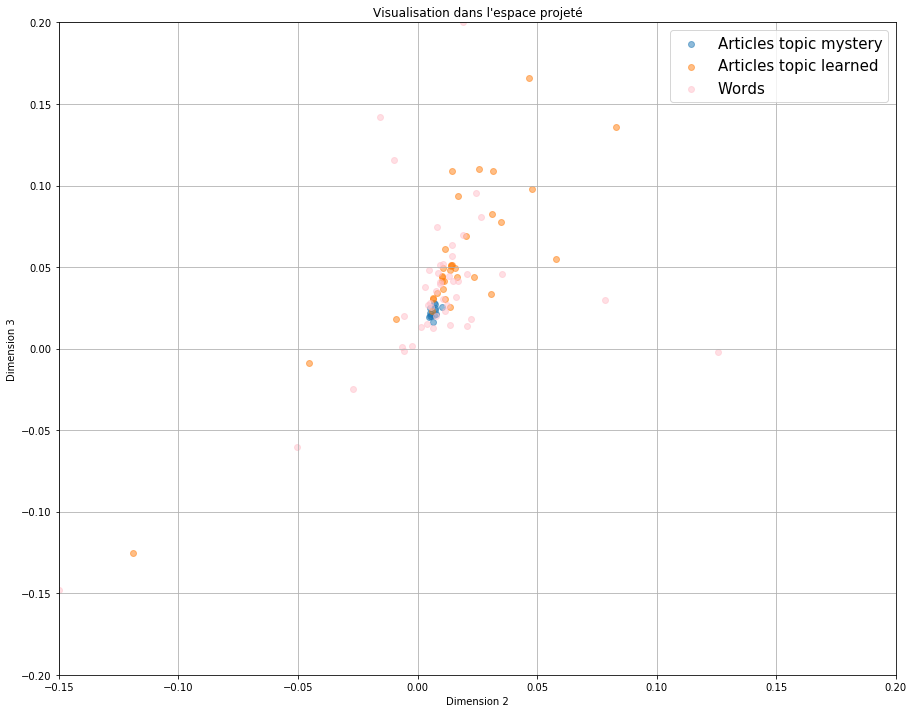

In [163]:
plot_lsa(X_brown, y_brown, feature_names_brown, ["learned", "mystery"], n=50, color="pink")

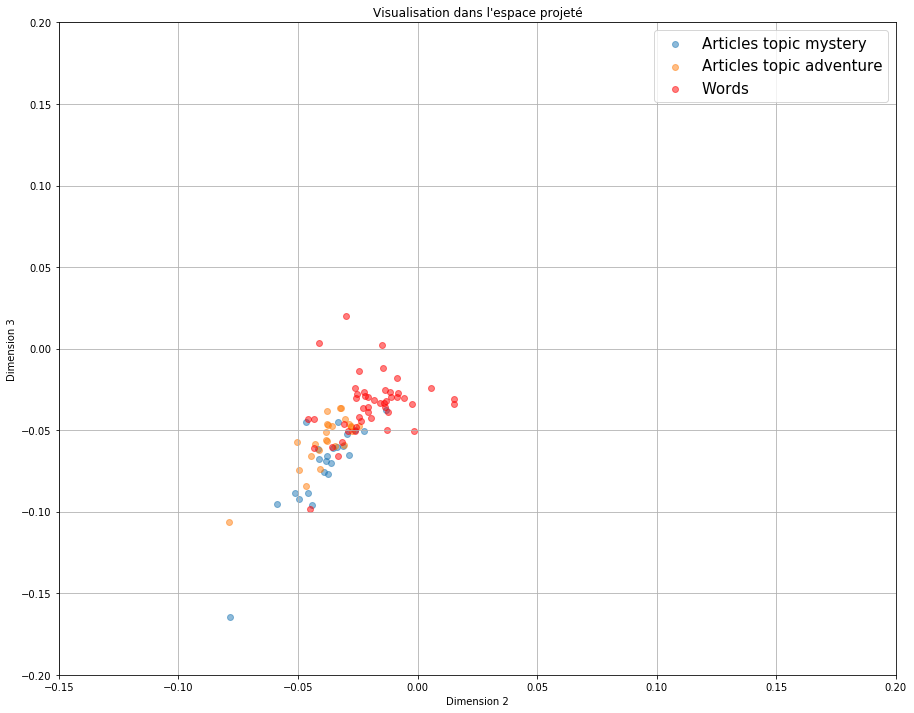

In [164]:
plot_lsa(X_brown, y_brown, feature_names_brown, ["adventure", "mystery"], n=50)

In [165]:
df_ng_train["category"].value_counts().index

Index(['rec.sport.hockey', 'soc.religion.christian', 'rec.motorcycles',
       'rec.sport.baseball', 'sci.crypt', 'sci.med', 'rec.autos', 'sci.space',
       'comp.windows.x', 'sci.electronics', 'comp.os.ms-windows.misc',
       'comp.sys.ibm.pc.hardware', 'misc.forsale', 'comp.graphics',
       'comp.sys.mac.hardware', 'talk.politics.mideast', 'talk.politics.guns',
       'alt.atheism', 'talk.politics.misc', 'talk.religion.misc'],
      dtype='object')

### Comment
- Again for the 20 Newsgroup data set, documents treating computer related things and gun talks are almost orthogonally distanced

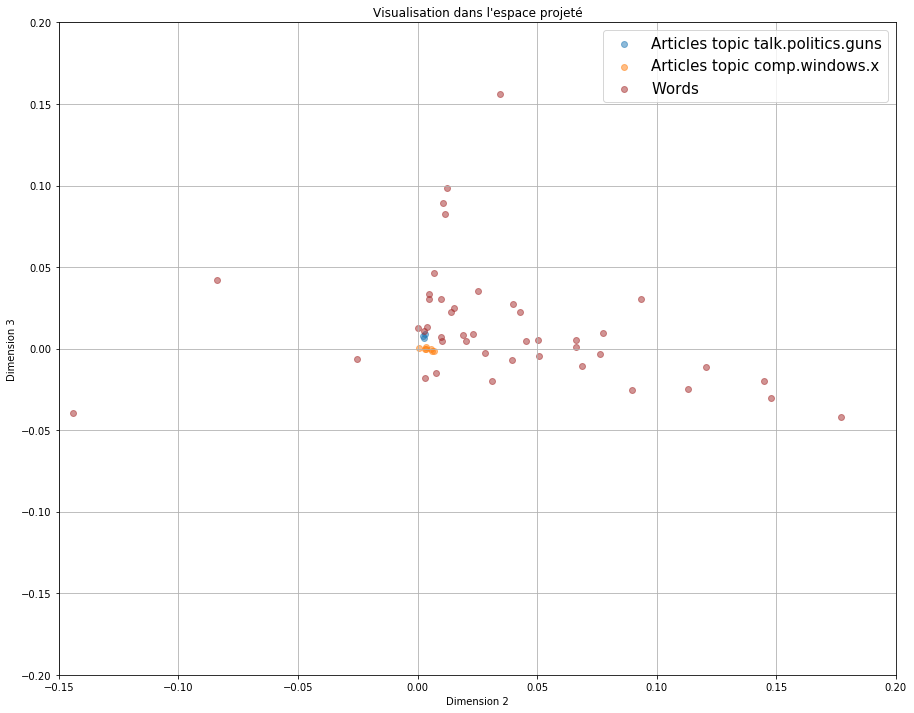

In [166]:
plot_lsa(X_ng, y_ng, feature_names_ng, ["talk.politics.guns", "comp.windows.x"], n=10, color="brown")